In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.formula.api as smf

from sklearn import ensemble, neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm


import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 25})
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Background 

Create a model to predict breast cancer. Also, what traits are most indicative of whether or not an individual will be diagnosed? The dataset can be found here:http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29

Given the data presented, I will use various classification models to see which models can most accurately predict breast cancer (using Class as the indicator) given the other nine factors.

## Attribute Information:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

In [2]:
cancer_data = pd.read_csv('breast-cancer-wisconsin.csv')

In [3]:
cancer_data.head()

,ID_Number,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
cancer_data['Bare_Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [4]:
# There were random question marks in the data set earlier. 
cancer_data = cancer_data.replace({'?':np.nan}).dropna()

In [6]:
cancer_data.describe()

,ID_Number,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [5]:
# Doesn't really matter, but turn class into cat. variable
# where malignant is 1 and benign is 0.
cancer_data['Class'] = cancer_data['Class'].map(lambda x: 1 if x==4 else 0)

In [6]:
# Check if we have an even distribution of cancer and non cancer
cancer_data['Class'].value_counts()

0    444
1    239
Name: Class, dtype: int64

In [7]:
from sklearn.utils import resample
# Lets upsample since the dataset is so small.
# So have more malignant samples.
cd_majority = cancer_data[cancer_data.Class==0]
cd_minority = cancer_data[cancer_data.Class==1]

# Upsample minority class
cd_minority_upsampled = resample(cd_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=444)    # to match majority class

 
# Combine majority class with upsampled minority class
cd_upsampled = pd.concat([cd_majority, cd_minority_upsampled])
 
# Display new class counts
cd_upsampled.Class.value_counts()

1    444
0    444
Name: Class, dtype: int64

# Answering the first question: What traits are most indicated that a person will be diagnosed?

In [8]:
# Try to figure out what are the most important features first. 
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest

# Set my variables.
skb_X = cd_upsampled.drop('Class', 1)
skb_y = cd_upsampled['Class']

# fit SelectKBest
skb_cancer = SelectKBest().fit(skb_X,skb_y)

# Identify features with highest score from a predictive perspective (for all programs) 
names = skb_X.columns
best_features = pd.DataFrame(skb_cancer.scores_, index = names) 
best_features.columns = ['Best Features'] 
best_features.sort_values(by=['Best Features'], ascending=True)

# Take a look at what the best features are.
print(best_features)

                             Best Features
ID_Number                         9.222399
Clump_Thickness                 953.458957
Uniformity_Cell_Size           1615.570226
Uniformity_Cell_Shape          1553.209030
Marginal_Adhesion               787.317888
Single_Epithelial_Cell_Size     731.247236
Bare_Nuclei                    1462.242822
Bland_Chromatin                1160.351941
Normal_Nucleoli                 801.405022
Mitoses                         161.898357


## The top 5 traits are:

1. Uniformity of Cell Size 
2. Uniformity of Cell Shape
3. Bare Nuclei
4. Bland Chromatin
5. Clump Thickness



# Model 1: Naive Bayes

In [9]:
# Set up variables
X = cd_upsampled.drop('Class', 1)
y = cd_upsampled.Class
# Create training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import MultinomialNB

# Instantiate our model and store it in a new variable.
mnb = MultinomialNB()


# Fit our model to the data.
mnb.fit(X_train, y_train)

# Classify, storing the result in a new variable.
y_pred_train = mnb.predict(X_test)

# Display our results.
print(str(100*mnb.fit(X_train, y_train).score(X_test, y_test)) + '%')

94.3820224719101%


In [11]:
# Lets check for overfitting now.
from sklearn.model_selection import cross_val_score
cross_val_score(mnb, X_train, y_train, cv=10)

array([0.95238095, 0.92063492, 0.9516129 , 0.9516129 , 0.93548387,
       0.9516129 , 0.91935484, 0.9516129 , 0.9516129 , 0.93442623])

In [12]:
# Results are consistent but lets check one last thing
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_train)

array([[135,   7],
       [  8, 117]])

# Analysis

This model did well due to the fact that multinomialNB looks at integers for feature counts and there weren't many anomalies/outliers in the features dataset which allowed the mNB model to predict accurately. Lastly, upsampling the dataset made sure that I could avoid any false negatives too.  


# Model 2: KNN 



In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
knn = KNeighborsClassifier()

# Set parameters for KNN
knn_params = [{'n_neighbors': [2,5,7,10,12,15,20]}]

# Search for the best paramters. 
knn_grid = GridSearchCV(knn, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(X_train, y_train)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters:
{'n_neighbors': 2}
Best Score:
0.6634460547504025


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished


In [31]:
# Initialize the model
knn = KNeighborsClassifier(n_neighbors=2)

# Lets check for overfitting now.
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X_train, y_train, cv=10)

array([0.66666667, 0.74603175, 0.66666667, 0.66666667, 0.68253968,
       0.72580645, 0.60655738, 0.67213115, 0.62295082, 0.68852459])

# Analysis

This model didn't perform as well which means that when the model was calculating the euclidean distance to find the closest neighbor, the closest neighbors must have been a mix up of the benign and malignant points. It might have increased in accuracy if I had first normalized the data so that the dataset would have had a more accurate representation of the distance. 

# Model 3: Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
dtc = DecisionTreeClassifier()

# Set parameters for dtc
dtc_params = [{'max_features': [2, 4, 6, 8],
             'max_depth': [2, 4, 6, 8]}]

# Search for the best paramters. 
dtc_grid = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
dtc_grid.fit(X_train, y_train)

# Return best parameters and best score
print('Best parameters:')
print(dtc_grid.best_params_)
print('Best Score:')
print(dtc_grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:
{'max_depth': 6, 'max_features': 6}
Best Score:
0.9694041867954911


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.1s finished


In [32]:
# Implement the parameters parameter 
dtc = DecisionTreeClassifier(max_features=6, max_depth=6)

# Cross Validate the decision tree model. 
cross_val_score(dtc, X_train, y_train, cv=5)

array([0.952     , 0.9516129 , 0.98387097, 0.97580645, 0.9516129 ])

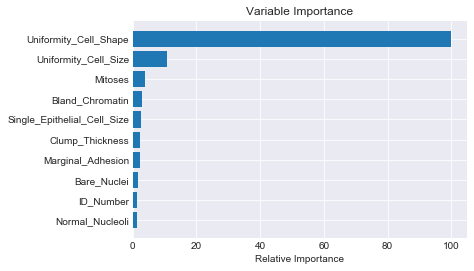

In [19]:
# Fit the model
dtc.fit(X_train, y_train)

# What's important?
feature_importance = dtc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Analysis

For this model, there were two variables that were different from selectkbest for the most important features. The decision tree may have been overfitted a bit which would explain how its so accurate. It's depth level and features are both 6 which allows it to explain more of the variance of the dataset. 

# Model 4: Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1)

#Fit the logistic regression 
lr_grid.fit(X_train, y_train)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best parameters:
{'C': 0.1}
Best Score:
0.9420289855072463


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished


In [33]:
# Implement parameter 
lr = LogisticRegression(C=.1)

# Cross Validate the lr model. 
cross_val_score(lr, X_train, y_train, cv=5)

array([0.912     , 0.94354839, 0.97580645, 0.94354839, 0.93548387])

In [22]:
# Fit the lr
lr.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)


Coefficients: 
 [[-1.61014175e-06  4.71780701e-02  6.14680680e-02  6.13244066e-02
   4.97367189e-02  3.76724607e-02  7.06458817e-02  4.62787344e-02
   5.26271063e-02  1.76440713e-02]]

Intercept: 
 [0.00050873]


# Analysis

For this logistic regression, I didn't bother using any regularizations because the dataset wasn't too big that it would overfit the coefficients and there weren't a lot of features to the point where I needed to remove them with the lasso regression. A logistic regression is perfect for a classification objective so I'm not surprised that this did so well. 

I tried looking for the feature importance by looking ad what the coefficients were but there aren't any distinct differences in the coefficients where I would say that one feature is superior to the other. 

# Model 5: Support Vector Classifier

In [23]:
from sklearn.svm import SVC

svm = SVC()

# new parameters for this model
svc_params = [{'C': [.00001,.0001,.001,.01,.1,1,
                    10,100,1000,10000],
              'gamma': [.00001,.0001,.001,.01,.1,1,10,25,100]}]

# setting up the grid
svc_grid = GridSearchCV(svm, svc_params, cv=5, verbose=1, n_jobs=-1)

#Fit the grid
svc_grid.fit(X_train, y_train)

#return best parameters and best score
print('Best parameters:')
print(svc_grid.best_params_)
print('Best Score:')
print(svc_grid.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.7s


Best parameters:
{'C': 10, 'gamma': 0.01}
Best Score:
0.8421900161030595


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.4s finished


In [34]:
# Implement the parameters parameter 
svm = SVC(C=10, gamma=.01)

# Cross Validate the svc model. 
cross_val_score(svm, X_train, y_train, cv=5)

array([0.848     , 0.83064516, 0.85483871, 0.82258065, 0.85483871])

# Analysis

The accuracy for the support vector is a bit lower than the other models and it's probably due to the fact that I didn't normalize the data which threw off the distancing for the datapoints. The reason it needs to be normalized is because it works similar to the knn but it has hyperplanes and accompanying margins to separate the two different datasets. Normalizing it would have created less noise and allow the margins to be bigger making it more accurate (bigger margins allow for a hard margin which allows for less noise.)

# Model 6: Gradient Boosting Model 

In [25]:
# Set up Gradient boosting parameters.
gb_params = [{'n_estimators': [100,200,500,800,1000],
             'max_depth': [2,4,6]
             }]

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier()

# Use the grid
gb_grid = GridSearchCV(clf, gb_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid
gb_grid.fit(X_train, y_train)

# Return best parameters and best score
print('Best parameters:')
print(gb_grid.best_params_)
print('Best Score:')
print(gb_grid.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    2.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    3.2s finished


Best parameters:
{'max_depth': 4, 'n_estimators': 500}
Best Score:
0.9838969404186796


In [35]:
# Implement the parameters parameter 
clf = ensemble.GradientBoostingClassifier(n_estimators=500, 
                                         max_depth=4, max_features='auto')

# Cross Validate the gradient boosting model. 
cross_val_score(clf, X_train, y_train, cv=5)

array([0.984     , 0.97580645, 0.98387097, 0.99193548, 0.97580645])

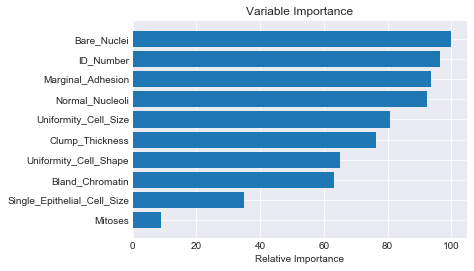

In [27]:
# Fit the model
clf.fit(X_train, y_train)

# What's important?
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Analysis

The most important features here were mostly the same except for one important difference, ID_number. This model's accuracy is strong since it runs iteratively the same data adjusting it's fit with the new results. ID number doesn't change so it makes sense that that would become a strong indicator for the model. The results may have been overfitted and I might have to remove ID_number in order to get a true accuracy for this model. 

# Model 7: Random Forest Classifier

In [28]:

# Prepare to use the random forest and GridSearchcV# Prepar 
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

rfc = ensemble.RandomForestClassifier()


# Create rfc parameters for GS-CV
param_grid = {'n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
             'max_features': [2, 4, 6, 8],
             'max_depth': [2, 4, 6, 8]}

# Set up GS-CV
grid = GridSearchCV(rfc, param_grid, cv=5, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', grid.best_params_)
print('\nBest Score for data:', grid.best_score_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   47.7s finished


Best Parameter for data: {'max_depth': 8, 'max_features': 2, 'n_estimators': 500}

Best Score for data: 0.9838969404186796


In [36]:
# Implement the parameters parameter 
rfc = ensemble.RandomForestClassifier(n_estimators=500, max_features=2,
                                     max_depth=8)

# Cross Validate the gradient boosting model. 
cross_val_score(clf, X_train, y_train, cv=5)

array([0.984     , 0.97580645, 0.98387097, 0.99193548, 0.97580645])

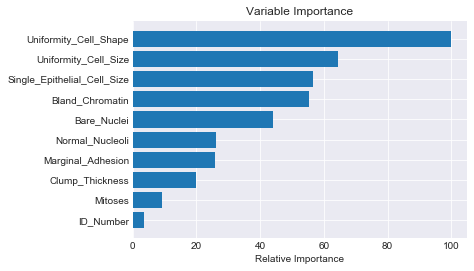

In [30]:
# Fit the model
rfc.fit(X_train, y_train)

# What's important?
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Analysis

The random forest model was also impressive. It didn't fall for the same trap as the gradient boosting model. This model's accuracy is probably due to the small data set which is why it didn't need that many estimators to accurately explain all the variance. The depth of 8 was probably what allowed the model to explain the slight variations in people who were diagnosed and probably covers the potential for there being false negatives in this model. 

# Modeling Data for PCA

In [8]:
# Prepare the data first for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
ss = StandardScaler()

# Set up the variables.
# Set up variables
X = cd_upsampled.drop('Class', 1)
y = cd_upsampled['Class'].values.reshape(-1, 1)

# Standarize the data first 
ss.fit(X,y)

# Now that the data is ready
transform_x = ss.transform(X, y)

In [9]:
# Use 4 components since it will explain most of the variance.
pca = PCA(n_components=4)

# Fit and transform the data.
principalComponents = pca.fit_transform(transform_x)

# Set up the new data frame. 
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2',
                         'principal component 3', 'principal component 4'])

# Model 1: PCA KNN 

In [14]:
# Set up variables.
pca_X = principalDf
y = cd_upsampled['Class'].values.reshape(-1, 1)

# Create training and testing set
X_train2, X_test2, y_train2, y_test2 = train_test_split(pca_X, y, test_size=0.3)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
knn = KNeighborsClassifier()

# Set parameters for KNN
knn_params = [{'n_neighbors': [2,5,7,10,12,15,20]}]

# Search for the best paramters. 
knn_grid = GridSearchCV(knn, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(X_train2, y_train2)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters:
{'n_neighbors': 20}
Best Score:
0.9758454106280193


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished


In [17]:
# Initialize the model
knn = KNeighborsClassifier(n_neighbors=20)

# Cross validate training set.
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X_train2, y_train2, cv=10)

array([0.96825397, 1.        , 0.98412698, 0.96825397, 0.98387097,
       0.9516129 , 0.98387097, 0.96721311, 0.98360656, 0.96721311])

In [23]:
# Results are consistent but lets check for false positive and negatives
from sklearn.metrics import confusion_matrix

# Fit the data
knn.fit(X_train2, y_train2)

# Set up the prediction set.
y_pred_train = knn.predict(X_test2)

confusion_matrix(y_test2, y_pred_train)

array([[127,   3],
       [  3, 134]])

In [24]:
# Evaluate the classification report.
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred_train))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       130
          1       0.98      0.98      0.98       137

avg / total       0.98      0.98      0.98       267



# Analysis 

This model did better than its non PCA counterpart. This is probably due to the fact that I had normalized the distance for the dataset preemptively since the PCA also requires the normalization of features. The confusion matrix showed me that there were only 3 false positives and 3 false negatives. 

# Model 2: PCA Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
dtc = DecisionTreeClassifier()

# Set parameters for dtc
dtc_params = [{'max_depth': [2, 4, 6, 8]}]

# Search for the best paramters. 
dtc_grid = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
dtc_grid.fit(X_train2, y_train2)

# Return best parameters and best score
print('Best parameters:')
print(dtc_grid.best_params_)
print('Best Score:')
print(dtc_grid.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters:
{'max_depth': 2}
Best Score:
0.9774557165861514


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


In [27]:
# Implement the parameters parameter 
dtc = DecisionTreeClassifier(max_features='auto', max_depth=2)

# Cross Validate the decision tree model. 
cross_val_score(dtc, X_train2, y_train2, cv=5)

array([0.984     , 0.976     , 0.81451613, 0.96774194, 0.71544715])

In [33]:
# Results are consistent but lets check for false positive and negatives
from sklearn.metrics import confusion_matrix

# Fit the data
dtc.fit(X_train2, y_train2)

# Set up the prediction set.
y_pred_train2 = dtc.predict(X_test2)

confusion_matrix(y_test2, y_pred_train)

array([[127,   3],
       [  0, 137]])

In [34]:
# Evaluate the classification report.
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred_train2))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99       130
          1       0.98      1.00      0.99       137

avg / total       0.99      0.99      0.99       267



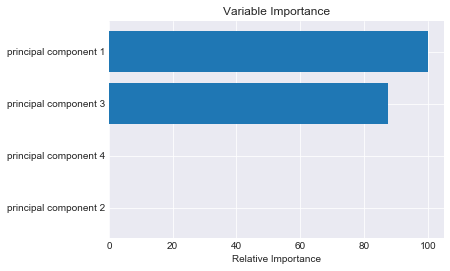

In [35]:
# Fit the model
dtc.fit(X_train2, y_train2)

# What's important?
feature_importance = dtc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Analysis

This model was slightly superior to the previous model due to the fact that there were no false negatives in this model. It was to my expectation that PC1 would be the most important feature since in PCA, the first components explain the majority of the variance of the dataset, but what was surprising was that PC3 had more of an impact than PC2. 

# Model 3: PCA Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1)

#Fit the logistic regression 
lr_grid.fit(X_train2, y_train2)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best parameters:
{'C': 1}
Best Score:
0.9726247987117552


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.1s finished


In [37]:
# Implement parameter 
lr = LogisticRegression(C=1)

# Cross Validate the lr model. 
cross_val_score(lr, X_train2, y_train2, cv=5)

array([0.96      , 0.984     , 0.97580645, 0.96774194, 0.97560976])

In [38]:
# Results are consistent but lets check for false positive and negatives

# Fit the data
lr.fit(X_train2, y_train2)

# Set up the prediction set.
y_pred_train3 = lr.predict(X_test2)

confusion_matrix(y_test2, y_pred_train3)

array([[127,   3],
       [  9, 128]])

In [39]:
# Evaluate the classification report.
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred_train3))

             precision    recall  f1-score   support

          0       0.93      0.98      0.95       130
          1       0.98      0.93      0.96       137

avg / total       0.96      0.96      0.96       267



# Analysis 
It made sense that the best C for the model was no change to the default value since I had already normalized the dataset. This model wasn't as accurate though with 9 false negatives. This might be due to the fact that the logistic classification isn't as complex as its predecessors so it's a bit less accurate.

# Model 4: PCA Support Vector Classifier

In [40]:
from sklearn.svm import SVC

svm = SVC()

# new parameters for this model
svc_params = [{'C': [.00001,.0001,.001,.01,.1,1,
                    10,100,1000,10000],
              'gamma': [.00001,.0001,.001,.01,.1,1,10,25,100]}]

# setting up the grid
svc_grid = GridSearchCV(svm, svc_params, cv=5, verbose=1, n_jobs=-1)

#Fit the grid
svc_grid.fit(X_train2, y_train2)

#return best parameters and best score
print('Best parameters:')
print(svc_grid.best_params_)
print('Best Score:')
print(svc_grid.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.6s


Best parameters:
{'C': 10, 'gamma': 0.1}
Best Score:
0.9726247987117552


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.2s finished


In [41]:
# Implement the parameters parameter 
svm = SVC(C=10, gamma=.01)

# Cross Validate the svc model. 
cross_val_score(svm, X_train, y_train, cv=5)

array([0.984     , 0.968     , 0.98387097, 0.95967742, 0.97560976])

In [44]:
# Results are consistent but lets check for false positive and negatives

# Fit the data
svm.fit(X_train2, y_train2)

# Set up the prediction set.
y_pred_train4 = svm.predict(X_test2)

confusion_matrix(y_test2, y_pred_train4)

array([[127,   3],
       [  4, 133]])

In [45]:
# Evaluate the classification report.
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred_train4))

             precision    recall  f1-score   support

          0       0.97      0.98      0.97       130
          1       0.98      0.97      0.97       137

avg / total       0.97      0.97      0.97       267



# Analysis

The accuracy of the support vector model has increased after the usage of PCA due to the fact that I had normalized the distances of the datapoints in the dataset. A surprising thing to notice is that the best parameters did not change even after using PCA. However, it's a bit more reasonable for the penalty term to be smaller since there are less features in this dataset which means that were would be less points on the plane. 

# Model 5: PCA Gradient Boosting Model 

In [46]:
# Set up Gradient boosting parameters.
gb_params = [{'n_estimators': [100,200,500,800,1000],
             'max_depth': [2,4,6]
             }]

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier()

# Use the grid
gb_grid = GridSearchCV(clf, gb_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid
gb_grid.fit(X_train2, y_train2)

# Return best parameters and best score
print('Best parameters:')
print(gb_grid.best_params_)
print('Best Score:')
print(gb_grid.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.9s finished


Best parameters:
{'max_depth': 4, 'n_estimators': 500}
Best Score:
0.9790660225442834


In [47]:
# Implement the parameters parameter 
clf = ensemble.GradientBoostingClassifier(n_estimators=500, 
                                         max_depth=4, max_features='auto')

# Cross Validate the gradient boosting model. 
cross_val_score(clf, X_train2, y_train2, cv=5)

array([0.992     , 0.968     , 0.96774194, 0.98387097, 0.98373984])

In [49]:
# Results are consistent but lets check for false positive and negatives

# Fit the data
clf.fit(X_train2, y_train2)

# Set up the prediction set.
y_pred_train5 = clf.predict(X_test2)

confusion_matrix(y_test2, y_pred_train5)

array([[127,   3],
       [  3, 134]])

In [50]:
# Evaluate the classification report.
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred_train5))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       130
          1       0.98      0.98      0.98       137

avg / total       0.98      0.98      0.98       267



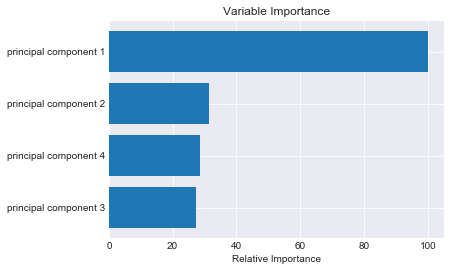

In [51]:
# Fit the model# Fit th 
clf.fit(X_train2, y_train2)

# What's important?
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Analysis

Performing the PCA had little to no difference from the previous dataset which is a testament to the strength of the GBM. Another reason why the PCA wasn't as effective on this dataset is probably due to how small it is and that the GBM had already done an excellent job without the PCA. The PCA actually weakened the gradient boosting model by almost 1%. The feature importance was more in line with the theory of PCA where PC1 explains the majority of the variance in the data set and the next component explains less than the previous. PC4 explains just a little bit more than PC3, but it is negligible. 

# Model 6: PCA Random Forest Classifier 

In [54]:
# Prepare to use the random forest and GridSearchcV# Prepar 
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

rfc = ensemble.RandomForestClassifier()


# Create rfc parameters for GS-CV
param_grid = {'n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
             'max_depth': [2, 4, 6, 8]}

# Set up GS-CV
grid = GridSearchCV(rfc, param_grid, cv=5, verbose=1, n_jobs=-1)

grid.fit(X_train2, y_train2)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', grid.best_params_)
print('\nBest Score for data:', grid.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameter for data: {'max_depth': 8, 'n_estimators': 10}

Best Score for data: 0.9806763285024155


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   15.3s finished


In [55]:
# Implement the parameters parameter 
rfc = ensemble.RandomForestClassifier(n_estimators=10, max_features='auto',
                                     max_depth=8)

# Cross Validate the gradient boosting model. 
cross_val_score(rfc, X_train2, y_train2, cv=5)

array([0.984     , 0.976     , 0.95967742, 0.97580645, 0.97560976])

In [56]:
# Results are consistent but lets check for false positive and negatives

# Fit the data
rfc.fit(X_train2, y_train2)

# Set up the prediction set.
y_pred_train6 = rfc.predict(X_test2)

confusion_matrix(y_test2, y_pred_train6)

array([[127,   3],
       [  3, 134]])

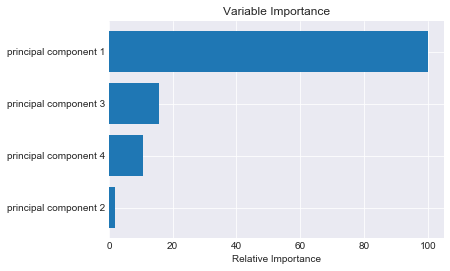

In [57]:
# Fit the model
rfc.fit(X_train2, y_train2)

# What's important?
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Analysis

The PCA model is once again less accurate than its predecessor by 1%. This time the optimal parameter was 10 trees compared to the previous 500 which tells me that the dataset revealed a lot more information this time comapared to before. Running the PCA before using the random forest shortened the run time by a significant amount and it seems that PC1 is still the strongest performer which is to be expected. I can't think of why PC2 would explain significantly less than PC3 and PC4. 